<a href="https://colab.research.google.com/github/zw2497/FlowerRecognition/blob/master/dl_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Recognition
Image Classification using a CNN on Flowers🌷

In this notebook, we will train a CNN-based image classifier to classify a couple thousand images of flowers, loaded from a directory on google drive.

We will compare three pretrained model: **VGG16, ResNet50, Inception**

The training will take **data augmentation, fine-tune**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download the [mini-flowers](https://storage.googleapis.com/applied-dl/mini_flowers.zip) dataset. 
This contains 1,500 images of five different types of flowers.

In [3]:
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip \
    -O /tmp/mini_flowers.zip

--2019-02-12 03:23:08--  https://storage.googleapis.com/applied-dl/mini_flowers.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40110537 (38M) [application/zip]
Saving to: ‘/tmp/mini_flowers.zip’

/tmp/mini_flowers.z 100%[===================>]  38.25M  32.1MB/s    in 1.2s    

2019-02-12 03:23:10 (32.1 MB/s) - ‘/tmp/mini_flowers.zip’ saved [40110537/40110537]



## Unzip dataset and explore data
Let's see how many image we have in each directory.

In [0]:
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/mini_flowers')
zip_ref.close()

In [0]:
base_dir = '/tmp/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [7]:
os.listdir('/tmp/mini_flowers/train')

['tulips', 'daisy', 'dandelion', 'sunflowers', 'roses']

In [0]:
label_names = os.listdir('/tmp/mini_flowers/train')
label_train_dirs = [os.path.join(train_dir, i) for i in label_names]
label_val_dirs = [os.path.join(validation_dir, i) for i in label_names]

In [10]:
for label_name, label_train_dir, label_val_dir  in zip(label_names, label_train_dirs, label_val_dirs):
  print(label_name, '- Training:',len(os.listdir(label_train_dir)), '- Val: ',len(os.listdir(label_val_dir)))

tulips - Training: 200 - Val:  100
daisy - Training: 200 - Val:  100
dandelion - Training: 200 - Val:  100
sunflowers - Training: 200 - Val:  100
roses - Training: 200 - Val:  100


## Adding data augmentation

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5)
validation_image_generator = ImageDataGenerator(rescale=1./255)

## Reading images off disk
We will use a couple handy utilities to read the images off disk, and to resize them to a consistent shape (and in the next notebook, to augment the training data). We will:

* Read the images from the disk
* Decode the JPGs into arrays of floating point values.
* Resize each image to be 150x150 pixels (our CNN requires all images to be the same shape).
* Rescale the pixel values from 0 and 255 to values between 0 and 1.

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32

In [76]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, # Best practice: shuffle the training data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='sparse')
total_train = train_data_gen.n

Found 1000 images belonging to 5 classes.


In [77]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='sparse')
total_val = val_data_gen.n

Found 500 images belonging to 5 classes.


**Let's take a look at some of the images we've loaded. **

* The *next* function returns a batch from the dataset. 
* The return values are in the form of (images, labels). 

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [18]:
print(sample_training_images[0].shape, sample_training_labels[0])

(150, 150, 3) 1.0


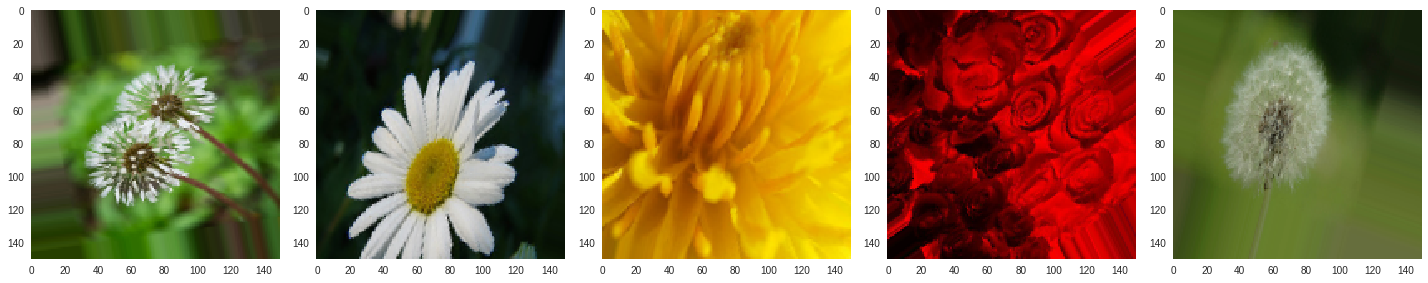

In [20]:
plotImages(sample_training_images[:5])

## Create and compile without pretrained model - baseline

In [0]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

In [0]:
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [0]:
EPOCHS = 50
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
10/10 [==============================] - 9s 855ms/step - loss: 1.6019 - acc: 0.2480 - val_loss: 1.4984 - val_acc: 0.3400
Epoch 2/50
10/10 [==============================] - 8s 819ms/step - loss: 1.3880 - acc: 0.3730 - val_loss: 1.1170 - val_acc: 0.5540
Epoch 3/50
10/10 [==============================] - 8s 824ms/step - loss: 1.1855 - acc: 0.4960 - val_loss: 1.2959 - val_acc: 0.5020
Epoch 4/50
10/10 [==============================] - 8s 819ms/step - loss: 1.0891 - acc: 0.5440 - val_loss: 1.2093 - val_acc: 0.5400
Epoch 5/50
10/10 [==============================] - 8s 828ms/step - loss: 1.0835 - acc: 0.5550 - val_loss: 1.0886 - val_acc: 0.5920
Epoch 6/50
10/10 [==============================] - 8s 817ms/step - loss: 1.0516 - acc: 0.5530 - val_loss: 1.2585 - val_acc: 0.5540
Epoch 7/50
10/10 [==============================] - 8s 823ms/step - loss: 1.0138 - acc: 0.5790 - val_loss: 1.4241 - val_acc: 0.5100
Epoch 8/50
10/10 [==============================] - 8s 814ms/step - loss: 0.

## Result of using CNN without data augmentation and pretrained model
* The model nearly overfitting at 5 epoch. 
* The avg accuracy is 63%

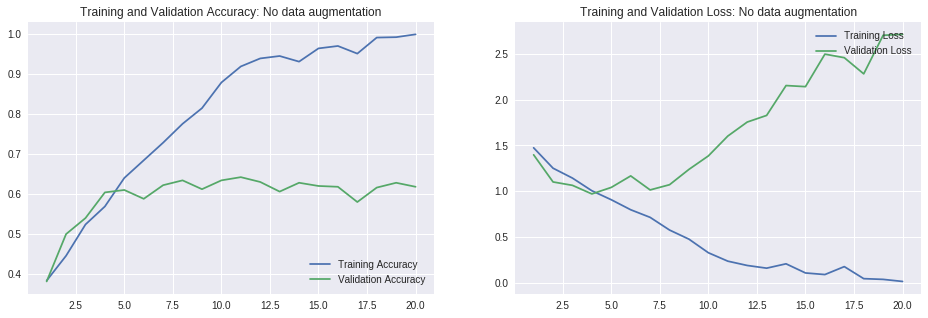

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: No data augmentation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: No data augmentation')
plt.show()

## Result of using CNN with data augmentation without pretrained model
* Accuracy: 70%


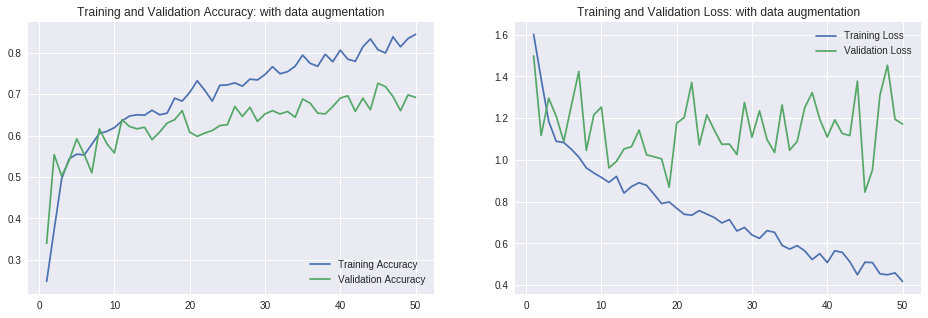

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: with data augmentation')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: with data augmentation')
plt.show()

## Add pretrain model
* VGG
* ResNet
* Inception

## VGG

In [0]:
from tensorflow.keras.applications import VGG16

In [0]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = False

In [25]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
model1 = Sequential([conv_base, Flatten(), Dense(256, activation='relu'), Dense(5, activation='softmax')])

In [38]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Now is a good time for a cup of coffee
EPOCHS = 100
history1 = model1.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
32/32 [==============================] - 12s 368ms/step - loss: 1.4682 - acc: 0.4820 - val_loss: 0.8200 - val_acc: 0.7080
Epoch 2/100
32/32 [==============================] - 9s 295ms/step - loss: 0.9170 - acc: 0.6540 - val_loss: 0.9297 - val_acc: 0.6660
Epoch 3/100
32/32 [==============================] - 10s 316ms/step - loss: 0.7532 - acc: 0.7230 - val_loss: 0.6721 - val_acc: 0.7680
Epoch 4/100
32/32 [==============================] - 10s 312ms/step - loss: 0.6779 - acc: 0.7340 - val_loss: 0.7001 - val_acc: 0.7480
Epoch 5/100
32/32 [==============================] - 10s 313ms/step - loss: 0.6810 - acc: 0.7440 - val_loss: 0.6057 - val_acc: 0.7840
Epoch 6/100
32/32 [==============================] - 10s 312ms/step - loss: 0.6217 - acc: 0.7740 - val_loss: 0.6106 - val_acc: 0.7820
Epoch 7/100
32/32 [==============================] - 10s 313ms/step - loss: 0.5732 - acc: 0.7910 - val_loss: 0.6930 - val_acc: 0.7820
Epoch 8/100
32/32 [==============================] - 10s 310ms/

## Result of VGG16 + Dense(256) + Dense(5)
* Accuracy: 81%

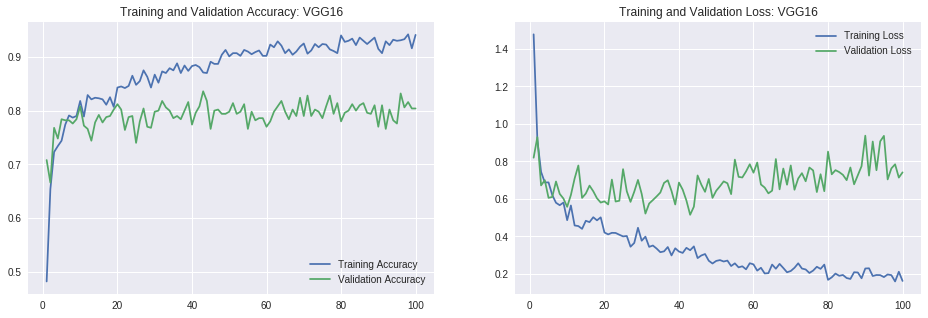

In [42]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: VGG16')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: VGG16')
plt.show()

## ResNET50

In [0]:
from tensorflow.keras.applications import ResNet50

In [48]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_base.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
model2 = Sequential([resnet_base, Flatten(), Dense(256, activation='relu'), Dense(5, activation='softmax')])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total params: 36,696,453
Trainable params: 13,108,741
Non-trainable params: 23,587,712
_________________________________________________________________


In [58]:
EPOCHS = 100
history2 = model2.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
)

Epoch 1/100
32/32 [==============================] - 15s 460ms/step - loss: 10.1673 - acc: 0.3390 - val_loss: 12.8725 - val_acc: 0.2000
Epoch 2/100
32/32 [==============================] - 10s 299ms/step - loss: 10.0275 - acc: 0.3630 - val_loss: 12.8299 - val_acc: 0.2000
Epoch 3/100
32/32 [==============================] - 11s 335ms/step - loss: 9.3361 - acc: 0.4040 - val_loss: 12.8575 - val_acc: 0.2000
Epoch 4/100
32/32 [==============================] - 11s 336ms/step - loss: 8.5113 - acc: 0.4590 - val_loss: 12.8756 - val_acc: 0.2000
Epoch 5/100
32/32 [==============================] - 11s 329ms/step - loss: 9.0182 - acc: 0.4330 - val_loss: 12.8929 - val_acc: 0.2000
Epoch 6/100
32/32 [==============================] - 11s 340ms/step - loss: 8.1235 - acc: 0.4850 - val_loss: 11.8136 - val_acc: 0.1560
Epoch 7/100
32/32 [==============================] - 11s 329ms/step - loss: 8.2718 - acc: 0.4750 - val_loss: 12.8767 - val_acc: 0.2000
Epoch 8/100
32/32 [==============================] - 

## Result of ResNET50

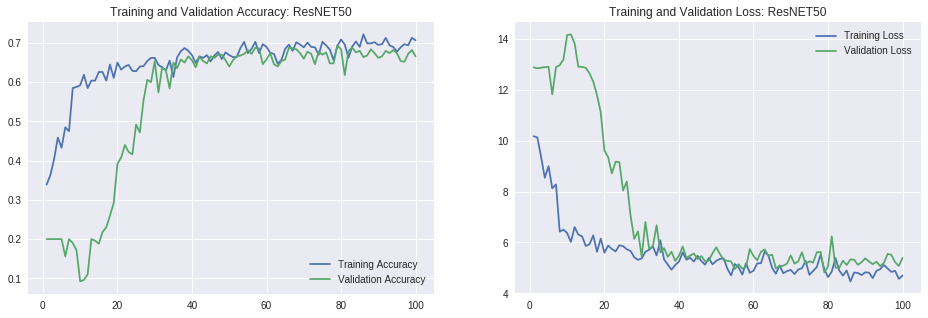

In [59]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: ResNET50')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: ResNET50')
plt.show()

# InceptionV3

In [0]:
from tensorflow.keras.applications import InceptionV3

In [0]:
inceptionV3_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
inceptionV3_base.trainable = False

In [80]:
model3 = Sequential([inceptionV3_base, Flatten(), Dense(256, activation='relu'), Dense(5, activation='softmax')])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_7 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 26,522,917
Trainable params: 4,720,133
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
EPOCHS = 100
history3 = model3.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
32/32 [==============================] - 16s 486ms/step - loss: 6.5210 - acc: 0.3120 - val_loss: 5.3045 - val_acc: 0.4580
Epoch 2/100
32/32 [==============================] - 9s 296ms/step - loss: 2.7833 - acc: 0.5280 - val_loss: 1.2048 - val_acc: 0.6420
Epoch 3/100
32/32 [==============================] - 10s 324ms/step - loss: 1.0937 - acc: 0.6140 - val_loss: 0.9780 - val_acc: 0.7080
Epoch 4/100
32/32 [==============================] - 10s 327ms/step - loss: 0.9174 - acc: 0.6880 - val_loss: 0.9140 - val_acc: 0.7120
Epoch 5/100
32/32 [==============================] - 11s 339ms/step - loss: 0.8525 - acc: 0.6990 - val_loss: 0.7375 - val_acc: 0.7420
Epoch 6/100
32/32 [==============================] - 10s 327ms/step - loss: 0.8743 - acc: 0.6900 - val_loss: 0.8293 - val_acc: 0.7220
Epoch 7/100
32/32 [==============================] - 11s 329ms/step - loss: 0.7463 - acc: 0.7460 - val_loss: 1.0245 - val_acc: 0.7100
Epoch 8/100
32/32 [==============================] - 10s 323ms/

## Result of InceptionV3

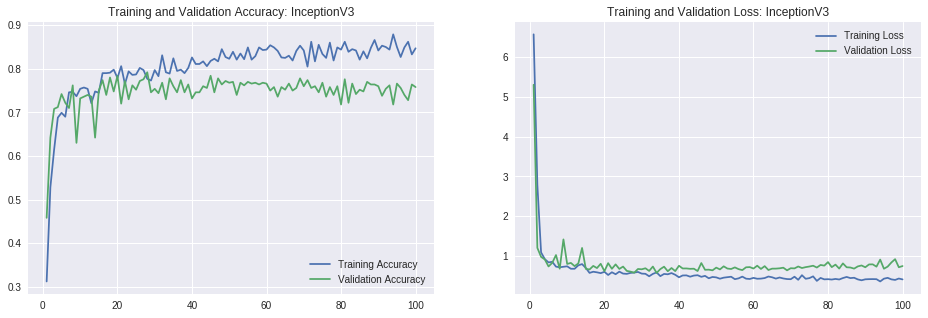

In [84]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: InceptionV3')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: InceptionV3')
plt.show()

# Conclusion

### Accuray comparasion:
* Convnet without data augmentation: 63%
* Convnet with data augmentation: 70%
* VGG: 80% **(Winner)**
* ResNet50: 67%
* InceptionV3: 75%

### conclusion
* **VGG16** converges quicker than **ResNet50**
* The training data and validation data of **VGG16** improves steadly, while **ResNet50** is hard to improve validation accuracy at first, but imporves quickly after a certain epoch
* The **InceptionV3** has very low loss but it's validation accuary still not improve
